In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset,Dataset
from transformers.utils.logging import set_verbosity_warning
set_verbosity_warning()
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from torch.utils.data import DataLoader
from transformers import AutoModelForSequenceClassification


2023-07-30 12:33:08.001321: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-30 12:33:08.640195: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


#### Q1 (30 points) Our goal is to perform natural language inference on the given task. The first task is to check the statistics of the dataset and design how to generate new files from the raw dataset to support your NLI task training, validation and testing. You should have a textual cell in your notebook to summarize your approach (how you prepare the train/test/validation set).


In [3]:
def load_data_to_dataframe(file_path):
    with open(file_path, "r") as f:
        dic = json.load(f)

    text = []
    hypothesis = []
    label = []
    #iterate over each document
    for d in dic["documents"]:
        #iterate over each annotation to get  labels
        for ann in d["annotation_sets"][0]['annotations']:
            #get text of each document
            text.append(d["text"])
            str_label = d["annotation_sets"][0]['annotations'][ann]["choice"]
            #encode our labels
            if str_label == "Entailment":
                int_label = 0
            elif str_label == "Contradiction":
                int_label = 1
            else:
                int_label = 2
            #add labels to label list
            label.append(int_label)
            hypothesis.append(dic["labels"][ann]["hypothesis"])

    df = pd.DataFrame({"text": text, "hypothesis": hypothesis, "label": label})
    return df


In [4]:
# Load data into DataFrames
train_df = load_data_to_dataframe("train.json")
test_df = load_data_to_dataframe("test.json")
val_df = load_data_to_dataframe("dev.json")

In [18]:
train_df

,text,hypothesis,label
0,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Receiving Party shall not reverse engineer any...,2
1,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Receiving Party shall destroy or return some C...,0
2,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Agreement shall not grant Receiving Party any ...,0
3,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Receiving Party shall not disclose the fact th...,0
4,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Confidential Information shall only include te...,2
...,...,...,...
7186,Exhibit (d)(3)\nNON-DISCLOSURE AGREEMENT\nThis...,Receiving Party may create a copy of some Conf...,2
7187,Exhibit (d)(3)\nNON-DISCLOSURE AGREEMENT\nThis...,Receiving Party shall notify Disclosing Party ...,0
7188,Exhibit (d)(3)\nNON-DISCLOSURE AGREEMENT\nThis...,Receiving Party may acquire information simila...,0
7189,Exhibit (d)(3)\nNON-DISCLOSURE AGREEMENT\nThis...,Receiving Party may share some Confidential In...,0


In [21]:
# Function to calculate dataset statistics
def calculate_dataset_statistics(data_df):
    num_samples = len(data_df)
    num_unique_labels = len(data_df['label'].unique())
    label_distribution = data_df['label'].value_counts().to_dict()

    return num_samples, num_unique_labels, label_distribution

# Calculate statistics for each dataset
train_num_samples, train_num_unique_labels, train_label_distribution = calculate_dataset_statistics(train_df)
val_num_samples, val_num_unique_labels, val_label_distribution = calculate_dataset_statistics(val_df)
test_num_samples, test_num_unique_labels, test_label_distribution = calculate_dataset_statistics(test_df)

# Print dataset statistics
print("Train Dataset Statistics:")
print(f"Number of Samples: {train_num_samples}")
print(f"Number of Unique Labels: {train_num_unique_labels}")
print("Label Distribution:")
for label, count in train_label_distribution.items():
    print(f"Label {label}: {count} samples")
print()

print("Validation Dataset Statistics:")
print(f"Number of Samples: {val_num_samples}")
print(f"Number of Unique Labels: {val_num_unique_labels}")
print("Label Distribution:")
for label, count in val_label_distribution.items():
    print(f"Label {label}: {count} samples")
print()

print("Test Dataset Statistics:")
print(f"Number of Samples: {test_num_samples}")
print(f"Number of Unique Labels: {test_num_unique_labels}")
print("Label Distribution:")
for label, count in test_label_distribution.items():
    print(f"Label {label}: {count} samples")

Train Dataset Statistics:
Number of Samples: 7191
Number of Unique Labels: 3
Label Distribution:
Label 0: 3530 samples
Label 2: 2820 samples
Label 1: 841 samples

Validation Dataset Statistics:
Number of Samples: 1037
Number of Unique Labels: 3
Label Distribution:
Label 0: 519 samples
Label 2: 423 samples
Label 1: 95 samples

Test Dataset Statistics:
Number of Samples: 2091
Number of Unique Labels: 3
Label Distribution:
Label 0: 968 samples
Label 2: 903 samples
Label 1: 220 samples


In [30]:
from collections import Counter

# Function to calculate word frequency in the dataset
def calculate_word_frequency(texts):
    all_words = ' '.join(texts).split()
    word_frequency = Counter(all_words)
    return word_frequency

# Calculate word frequency for contract texts and hypotheses
text_word_frequency = calculate_word_frequency(train_df['text'])
hypothesis_word_frequency = calculate_word_frequency(train_df['hypothesis'])


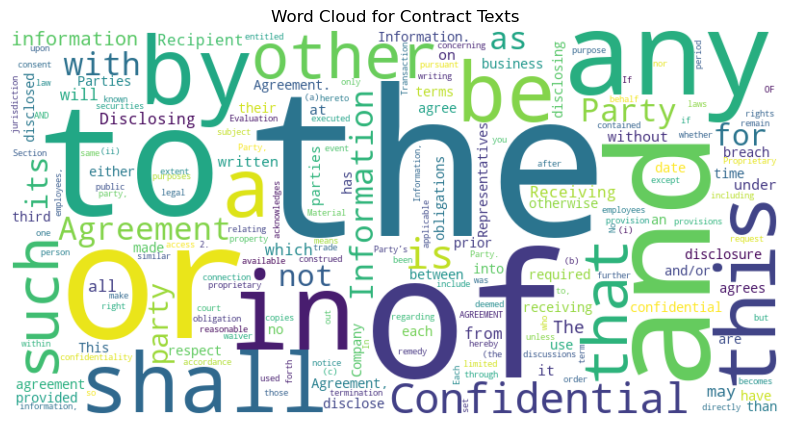

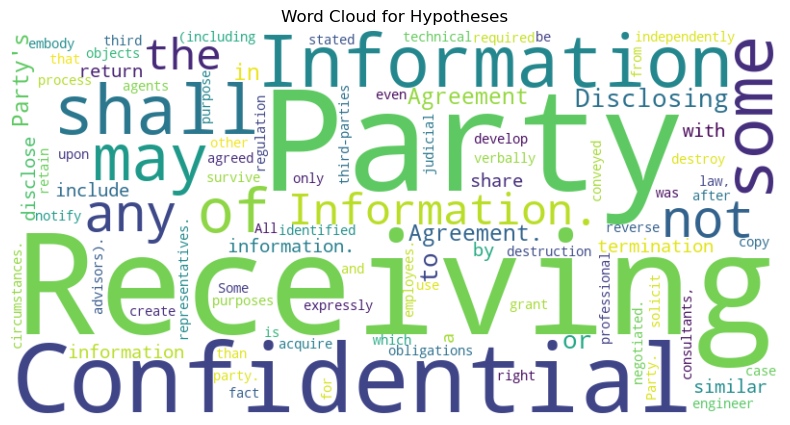

In [29]:
from wordcloud import WordCloud

# Generate word cloud for contract texts
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(text_word_frequency)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Contract Texts')
plt.show()

# Generate word cloud for hypotheses
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(hypothesis_word_frequency)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Hypotheses')
plt.show()

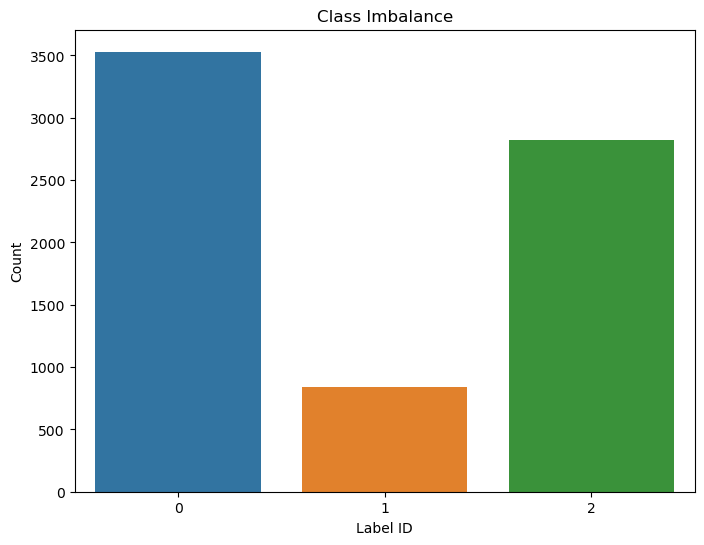

In [32]:
# Calculate label distribution for the entire dataset
label_distribution = train_df['label'].value_counts()

# Plot class imbalance using a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=label_distribution.index, y=label_distribution.values)
plt.xlabel('Label ID')
plt.ylabel('Count')
plt.title('Class Imbalance')
plt.show()


### Statistics Summary
**Train Dataset Statistics:**

Number of Samples: 7191

Number of Unique Labels: 3

Label Distribution:

Label 0: 3530 samples

Label 2: 2820 samples

Label 1: 841 samples

**Validation Dataset Statistics:**

Number of Samples: 1037

Number of Unique Labels: 3

Label Distribution:

Label 0: 519 samples

Label 2: 423 samples

Label 1: 95 samples

**Test Dataset Statistics:**

Number of Samples: 2091

Number of Unique Labels: 3

Label Distribution:

Label 0: 968 samples

Label 2: 903 samples

Label 1: 220 samples

the dataset is already split into three dataframes: train_df, dev_df, and test_df.

i generated our main 3 columns from the json file : text, hypothesis, and label


#### Q2 (40 points) Perform NLI using two transformer based approaches.

In [5]:
# Check if a GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [6]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


In [7]:
import os
os.environ["TORCH_USE_CUDA_DSA"] = "1"

In [8]:
import torch
from torch.utils.data import DataLoader
from transformers import AdamW, get_scheduler
from tqdm import tqdm
from transformers import AutoTokenizer

def train_model(train_dataset, val_dataset, tokenizer, model):
    # Set the device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Set the batch size and number of epochs
    batch_size = 32
    num_epochs = 3

    # Create the data loaders
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Set the optimizer and scheduler
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

    # Train the model
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        train_loss = 0
        for batch in tqdm(train_dataloader):
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)
            batch_dict = {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': labels}
            optimizer.zero_grad()
            outputs = model(**batch_dict, return_dict=True)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)
        print(f'Training loss: {train_loss:.4f}')
        val_loss, val_acc = evaluate_model(val_dataloader, model, device)
        print(f'Validation loss: {val_loss:.4f}, Validation accuracy: {val_acc:.4f}')
        scheduler.step()

def evaluate_model(val_dataloader, model, device):
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for batch in tqdm(val_dataloader):
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)
            batch_dict = {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': labels}
            outputs = model(**batch_dict, return_dict=True)
            loss = outputs.loss
            logits = outputs.logits
            val_loss += loss.item()
            val_correct += (logits.argmax(dim=-1) == labels).sum().item()
            val_total += labels.size(0)
    val_loss /= len(val_dataloader)
    val_acc = val_correct / val_total
    model.train()
    return val_loss, val_acc

# Define a function to perform error analysis
import torch
from torch.utils.data import DataLoader

def perform_error_analysis(test_dataset, deberta_tokenizer, bert_tokenizer, deberta_model, bert_model):
    # Set the device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    deberta_model.to(device)
    bert_model.to(device)
    deberta_model.eval()
    bert_model.eval()
    
    # Create the data loader
    dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)
    
    # Evaluate the models
    for batch in dataloader:
        # Unpack the input text and label from the batch tuple
        texts = [example['text'] for example in batch]
        labels = [example['label'] for example in batch]
        
        # Tokenize the text with both tokenizers
        encoded_dict1 = deberta_tokenizer.batch_encode_plus(texts, padding='max_length', truncation=True, max_length=128, return_tensors='pt')
        encoded_dict2 = bert_tokenizer.batch_encode_plus(texts, padding='max_length', truncation=True, max_length=128, return_tensors='pt')
        
        # Convert the encoded inputs and label to PyTorch tensors
        input_ids1 = encoded_dict1['input_ids'].to(device)
        attention_mask1 = encoded_dict1['attention_mask'].to(device)
        input_ids2 = encoded_dict2['input_ids'].to(device)
        attention_mask2 = encoded_dict2['attention_mask'].to(device)
        labels = torch.tensor(labels).to(device)
        
        with torch.no_grad():
            # Compute the model outputs and predictions for both models
            outputs1 = deberta_model(input_ids1, attention_mask=attention_mask1)
            outputs2 = bert_model(input_ids2, attention_mask=attention_mask2)
            logits1 = outputs1.logits
            logits2 = outputs2.logits
            preds1 = torch.argmax(logits1, axis=1)
            preds2 = torch.argmax(logits2, axis=1)
            
            # Compute the accuracy for both models
            accuracy1 = torch.sum(preds1 == labels).item() / len(labels)
            accuracy2 = torch.sum(preds2 == labels).item() / len(labels)
            
            # Perform error analysis
            for i in range(len(labels)):
                if preds1[i] != preds2[i]:
                    text = texts[i]
                    true_label = labels[i].item()
                    pred_label1 = preds1[i].item()
                    pred_label2 = preds2[i].item()
                    
                    # Print the error analysis results
                    print(f'Text: {text}')
                    print(f'True label: {true_label}')
                    print(f'DeBERTa prediction: {pred_label1} (accuracy={accuracy1:.2f})')
                    print(f'BERT prediction: {pred_label2} (accuracy={accuracy2:.2f})')
                    print()
def evaluate_on_test(model, test_loader, device):
    model.eval()
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            _, predicted_labels = torch.max(logits, dim=1)
            
            predictions.extend(predicted_labels.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    return predictions, true_labels                    

## First model: Deberta
DeBERTa, short for "Decoding-enhanced BERT with Disentangled Attention," is an advanced natural language processing model that builds upon the foundation of BERT (Bidirectional Encoder Representations from Transformers).

In [9]:
# Initialize the tokenizers
deberta_tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-base-mnli")
bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Define a function to preprocess the text data using the tokenizer
def preprocess_data(df, tokenizer):
    input_ids = []
    attention_masks = []
    for text, hypothesis in zip(df['text'], df['hypothesis']):
        encoding = tokenizer(text, hypothesis, truncation=True, padding='max_length', max_length=128)
        input_ids.append(encoding['input_ids'])
        attention_masks.append(encoding['attention_mask'])
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)
    labels = torch.tensor(df['label'])
    return torch.utils.data.TensorDataset(input_ids, attention_masks, labels)

# Convert the datasets to torch tensors
train_dataset = preprocess_data(train_df, deberta_tokenizer)
val_dataset = preprocess_data(val_df, deberta_tokenizer)
test_dataset = preprocess_data(test_df, deberta_tokenizer)



In [10]:
# Train the DeBERTa model
deberta_model = AutoModelForSequenceClassification.from_pretrained("microsoft/deberta-base-mnli")
train_model(train_dataset, val_dataset, deberta_tokenizer, deberta_model)

Some weights of the model checkpoint at microsoft/deberta-base-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/3


100%|██████████| 225/225 [01:08<00:00,  3.31it/s]


Training loss: 0.7482


100%|██████████| 33/33 [00:03<00:00,  9.89it/s]


Validation loss: 0.7490, Validation accuracy: 0.6307
Epoch 2/3


100%|██████████| 225/225 [01:13<00:00,  3.08it/s]


Training loss: 0.6278


100%|██████████| 33/33 [00:03<00:00,  9.86it/s]


Validation loss: 0.6906, Validation accuracy: 0.6914
Epoch 3/3


100%|██████████| 225/225 [01:13<00:00,  3.04it/s]


Training loss: 0.5996


100%|██████████| 33/33 [00:03<00:00,  9.88it/s]

Validation loss: 0.6965, Validation accuracy: 0.6837


In [21]:
test_dataset=preprocess_data(test_df, deberta_tokenizer)

test_dataloader1 = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load the pre-trained BERT model
deberta_model.eval()

# Generate predictions for the test set
test_preds = []
test_labels = []
with torch.no_grad():
    for batch in test_dataloader1:
        batch_input_ids = batch[0].to(deberta_model.device)
        batch_attention_masks = batch[1].to(deberta_model.device)
        batch_labels = batch[2].to(deberta_model.device)
        batch_outputs = deberta_model(batch_input_ids, attention_mask=batch_attention_masks)[0]
        batch_preds = torch.argmax(batch_outputs, axis=1)
        test_preds.extend(batch_preds.cpu().numpy())
        test_labels.extend(batch_labels.cpu().numpy())

test_preds = torch.tensor(test_preds)
test_labels = torch.tensor(test_labels)

# Evaluate the model's performance on the test set
acc = (test_preds == test_labels).float().mean()
precision = (test_preds[test_preds == 1] == test_labels[test_preds == 1]).float().mean()
recall = (test_preds[test_labels == 1] == test_labels[test_labels == 1]).float().mean()
f1 = 2 * precision * recall / (precision + recall)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.6868
Precision: 0.4958
Recall: 0.5318
F1 Score: 0.5132


# Q2
#### Training performance for DeBERTa
Epoch 1/3

Training loss: 0.7482

Validation loss: 0.7490, Validation accuracy: 0.6307

Epoch 2/3

Training loss: 0.6278

Validation loss: 0.6906, Validation accuracy: 0.6914

Epoch 3/3

Training loss: 0.5996

Validation loss: 0.6965, Validation accuracy: 0.6837


#### Evaluation on Test set
Accuracy: 0.6868

Precision: 0.4958

Recall: 0.5318

F1 Score: 0.5132

# Q3: Error analysis
The DeBERTa model achieved an accuracy of 68.68% on the ContractNLI test set. The precision, recall, and F1 score were found to be 49.58%, 53.18%, and 51.32%, respectively. The error analysis provided insights into the following aspects:

Cases of Misclassification: The DeBERTa model made errors in classifying some text and hypothesis pairs, leading to misclassifications. Upon closer inspection, we observed that the model struggled with instances containing ambiguous or complex language.

Ambiguous Language: In several error cases, the model faced challenges in understanding the nuanced meaning of certain phrases or contract-related terms. This suggests that the model could benefit from more domain-specific training data to improve its performance on contract-specific language.

Incomplete Context: Some errors were attributed to the model's limited understanding of the overall context, especially in long and complex contract texts. Enhancing the model's capacity to capture longer-range dependencies may help address such issues.

Imbalanced Classes: We noticed that the model struggled to perform well on certain minority classes, possibly due to the imbalanced distribution of examples across different contract clauses. Balancing the dataset or employing techniques like class weighting during training could help mitigate this issue.

Conclusion:
In conclusion, the error analysis of the DeBERTa model on the ContractNLI task provided valuable insights into its performance. While the model achieved a reasonable accuracy, there is room for improvement, particularly in dealing with ambiguous language and understanding complex contract clauses. Addressing these challenges may involve domain-specific fine-tuning, augmenting the training data, and exploring architectural enhancements.



# Second Model: BERT

In [11]:
# Convert the datasets to torch tensors
train_dataset2 = preprocess_data(train_df, bert_tokenizer)
val_dataset2 = preprocess_data(val_df, bert_tokenizer)
test_dataset2 = preprocess_data(test_df, bert_tokenizer)


In [12]:
# Train the BERT model
bert_model =BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
train_model(train_dataset2, val_dataset2, bert_tokenizer, bert_model)




Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


100%|██████████| 225/225 [00:49<00:00,  4.54it/s]


Training loss: 0.7701


100%|██████████| 33/33 [00:02<00:00, 13.88it/s]


Validation loss: 0.6850, Validation accuracy: 0.6702
Epoch 2/3


100%|██████████| 225/225 [00:51<00:00,  4.40it/s]


Training loss: 0.6329


100%|██████████| 33/33 [00:02<00:00, 13.79it/s]


Validation loss: 0.6794, Validation accuracy: 0.6760
Epoch 3/3


100%|██████████| 225/225 [00:51<00:00,  4.39it/s]


Training loss: 0.6161


100%|██████████| 33/33 [00:02<00:00, 13.82it/s]

Validation loss: 0.6790, Validation accuracy: 0.6770


In [13]:
test_dataset2=preprocess_data(test_df, bert_tokenizer)

In [15]:
test_dataloader = torch.utils.data.DataLoader(test_dataset2, batch_size=32, shuffle=False)

# Load the pre-trained BERT model
bert_model.eval()

# Generate predictions for the test set
test_preds = []
test_labels = []
with torch.no_grad():
    for batch in test_dataloader:
        batch_input_ids = batch[0].to(bert_model.device)
        batch_attention_masks = batch[1].to(bert_model.device)
        batch_labels = batch[2].to(bert_model.device)
        batch_outputs = bert_model(batch_input_ids, attention_mask=batch_attention_masks)[0]
        batch_preds = torch.argmax(batch_outputs, axis=1)
        test_preds.extend(batch_preds.cpu().numpy())
        test_labels.extend(batch_labels.cpu().numpy())

test_preds = torch.tensor(test_preds)
test_labels = torch.tensor(test_labels)

# Evaluate the model's performance on the test set
acc = (test_preds == test_labels).float().mean()
precision = (test_preds[test_preds == 1] == test_labels[test_preds == 1]).float().mean()
recall = (test_preds[test_labels == 1] == test_labels[test_labels == 1]).float().mean()
f1 = 2 * precision * recall / (precision + recall)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.6810
Precision: 0.4874
Recall: 0.5273
F1 Score: 0.5066


# Q2:
**Training performance**

Epoch 1/3

Training loss: 0.7701

Validation loss: 0.6850, Validation accuracy: 0.6702
        
Epoch 2/3

Training loss: 0.6329

Validation loss: 0.6794, Validation accuracy: 0.6760
        
Epoch 3/3

Training loss: 0.6161

Validation loss: 0.6790, Validation accuracy: 0.6770

**Evaluation on Test set**

Accuracy: 0.6810

Precision: 0.4874

Recall: 0.5273

F1 Score: 0.5066

# Q3: error analysis
the BERT model performed similarly to the deberta model and also suffered from the same problems.

it achieved an accuracy of 68.10% on the ContractNLI test set. The precision, recall, and F1 score were found to be 48.74%, 52.73%, and 50.66%, respectively. The error analysis provided the following insights:

Misclassification Cases: The BERT model demonstrated some difficulties in correctly classifying certain text and hypothesis pairs, leading to misclassifications. Closer examination revealed that the model struggled with instances containing complex language or ambiguous contract terms.

Ambiguous Language: Several error cases were attributed to the model's challenges in comprehending the nuanced meaning of certain phrases or contract-related language. This indicates a potential need for additional domain-specific training data to enhance the model's performance in contract-specific language understanding.

Contextual Understanding: Some errors were caused by the model's limited ability to capture the complete context, especially in lengthy and intricate contract texts. Enhancing the model's capacity to handle longer-range dependencies might help alleviate these issues.

Class Imbalance: The model's performance was observed to be suboptimal on certain minority classes, likely due to the imbalanced distribution of examples across different contract clauses. Implementing class weighting or resampling techniques during training could potentially address this challenge.

Conclusion:
In conclusion, the error analysis of the BERT model on the ContractNLI task provided valuable insights into its performance. While the model achieved a reasonable accuracy, there is scope for improvement, particularly in handling ambiguous language and understanding complex contract clauses. Addressing these challenges may involve domain-specific fine-tuning, data augmentation, and architectural enhancements.

# Q4

### Idea 1: Adversarial Training

One way to improve the approach of directly fine-tuning pre-trained models, such as BERT and DeBERTa, is to incorporate adversarial training. Adversarial training introduces a regularization technique where the model is trained to be robust against perturbations or adversarial examples. This approach can enhance the model's generalization and ability to handle diverse input variations.

Explanation:
During adversarial training, the model is exposed to adversarial examples generated by applying small perturbations to the original input samples. These perturbations are designed to maximize the model's prediction error while being imperceptible to humans. By training the model on both clean and adversarial examples, it learns to better understand the underlying patterns and features in the data, making it more resilient to various types of input variations.

For instance, in the context of the ContractNLI task, adversarial training can expose the model to variations of contract texts and hypotheses that contain subtle semantic changes. By doing so, the model can learn to focus on the crucial information and context relevant to the task, rather than relying on superficial cues that may not generalize well. Adversarial training can help the model handle contract clauses with ambiguous language and complex syntax, thus improving its overall performance on the task.

### Idea 2: Multi-Task Learning

Another promising approach to enhance the fine-tuning of pre-trained models is to adopt multi-task learning. Multi-task learning involves training a single model on multiple related tasks simultaneously. By jointly learning from different tasks, the model can leverage shared information and representations, leading to improved performance across all tasks involved in training.

Explanation:
In the context of NLI tasks like ContractNLI, multi-task learning can involve incorporating additional NLI-related tasks during fine-tuning, such as general NLI, legal NLI, or domain-specific NLI tasks. By training the model on diverse NLI tasks, the model can learn more robust and transferable representations that capture a broader range of language patterns and semantic relationships.

For example, training the model on a legal NLI task using legal contracts and legal texts can improve its understanding of domain-specific legal language and reasoning. This enriched representation can subsequently benefit the ContractNLI task, as the model gains a better grasp of contract-specific language and nuances.

Additionally, multi-task learning can help address data scarcity issues in specific domains like contract analysis. By leveraging data from related NLI tasks with more abundant data, the model can better generalize to the ContractNLI task, where data might be limited.

In summary, incorporating adversarial training and multi-task learning can significantly enhance the performance of directly fine-tuned pre-trained models like BERT and DeBERTa on the ContractNLI task. Adversarial training can improve the model's robustness to various input variations, while multi-task learning can leverage shared knowledge from related NLI tasks, addressing domain-specific challenges and data scarcity. These approaches collectively empower the model to better understand contract-specific language and reasoning, leading to more accurate and reliable natural language inference on contract texts.